In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import poisson
import ast, pickle

from Class_utils.parameters import *
from Class_utils.FitnessClasses import *

from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

# Distributions

In [40]:
dt_language = pd.read_csv(file_paths["languages_path"],index_col=0)
dt_language.sort_values("Prob",ascending=False,inplace=True)

df_language_level = pd.read_csv(file_paths["languages_level_path"],index_col=0) # dataframe with language levels
df_language_level = df_language_level.merge(dt_language, left_index=True, right_index=True)
df_language_level.sort_values(by="Prob",ascending=False).drop("Prob",axis=1,inplace=True)
 
poisson_dist = pd.DataFrame([poisson(lam=2) for _ in range(60000)], columns=["Values"])
opt_lang_dist = pd.DataFrame(file_paths["opt_lang_distribution"], columns=["Dist"])

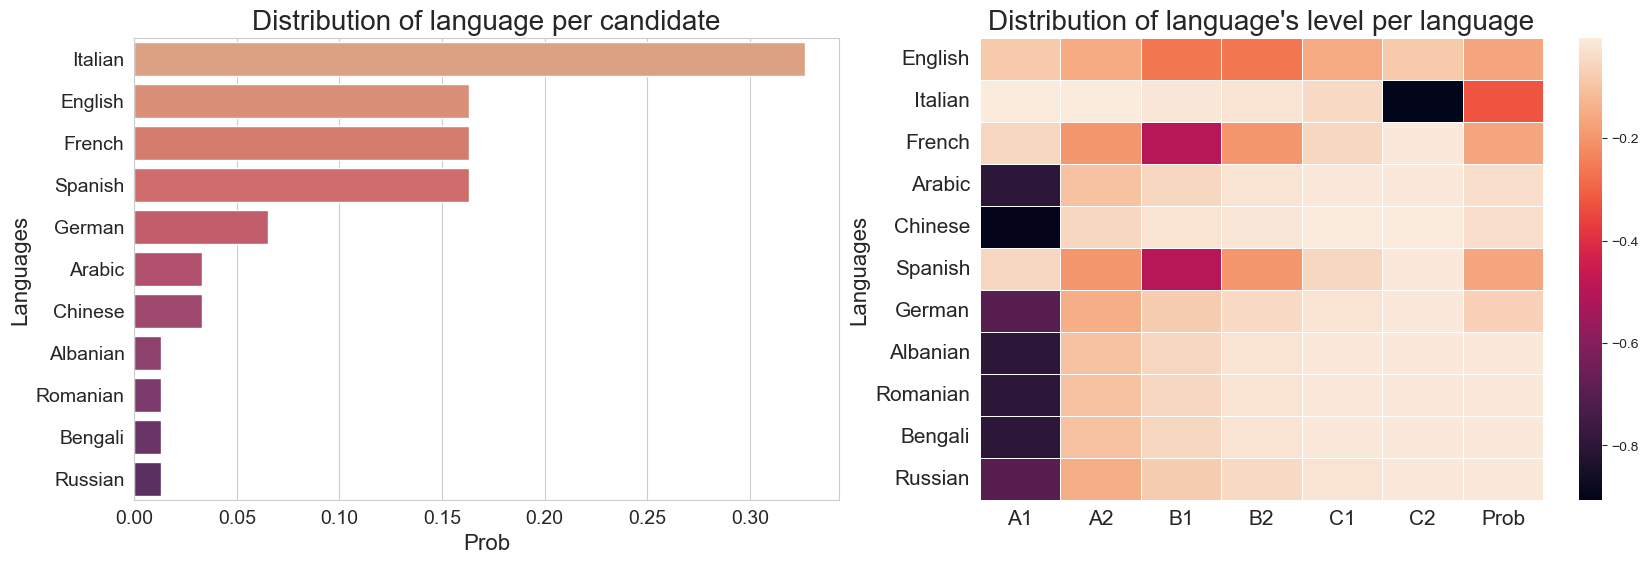

In [41]:
_, axs = plt.subplots(ncols=2,nrows=1,figsize=(20, 6))

sns.barplot(x=dt_language["Prob"], y=dt_language.index, data=dt_language,
            palette="flare", ax=axs[0])
axs[0].set_title('Distribution of language per candidate', fontsize=20)
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_xlabel(axs[0].get_xlabel(), fontsize=16)
axs[0].set_ylabel(axs[0].get_ylabel(), fontsize=16)

sns.heatmap(-df_language_level, linewidths=.5, ax=axs[1])
axs[1].set_title('Distribution of language\'s level per language', fontsize=20)
axs[1].tick_params(axis='both', labelsize=15)
axs[1].set_ylabel(axs[0].get_ylabel(), fontsize=16)

plt.show()

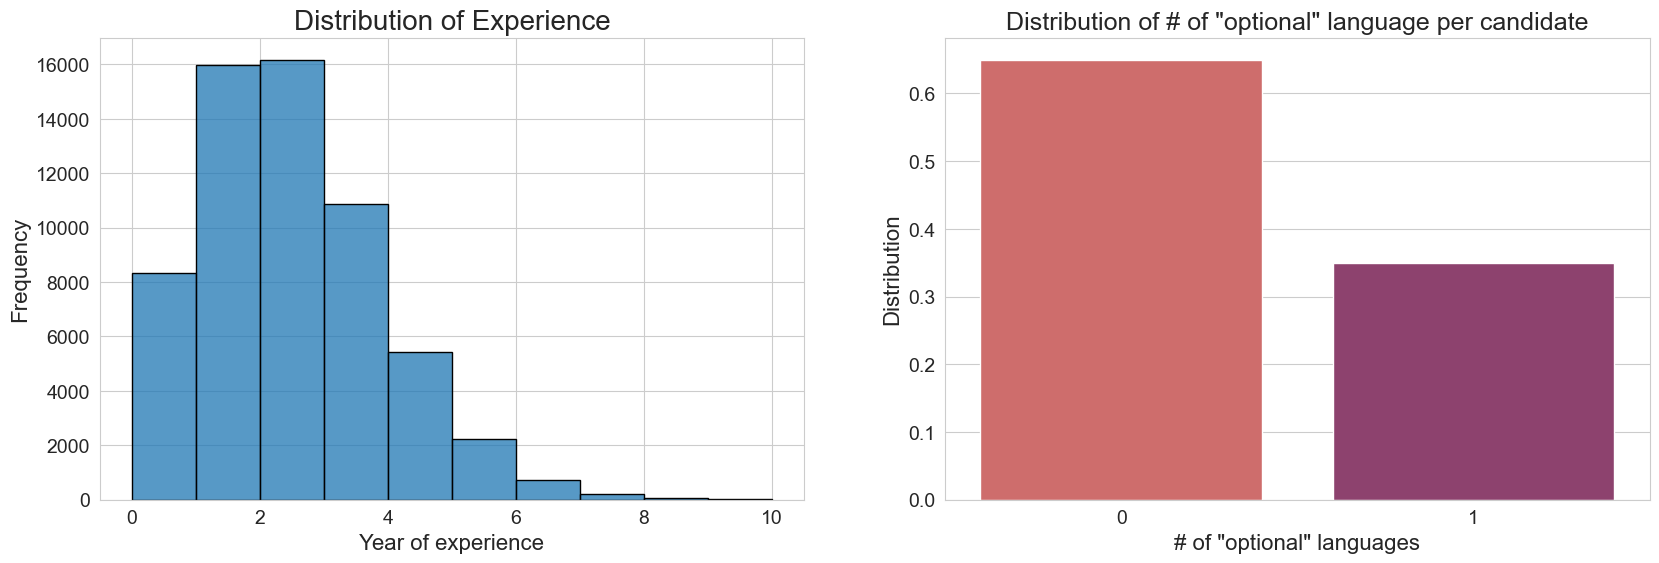

In [42]:
_, axs = plt.subplots(ncols=2,nrows=1,figsize=(20,6))

sns.histplot(poisson_dist["Values"], bins=10, edgecolor='black', ax=axs[0])
axs[0].set_title('Distribution of Experience', fontsize=20)
axs[0].set_xlabel('Year of experience', fontsize=16)
axs[0].set_ylabel('Frequency', fontsize=16)
axs[0].tick_params(axis='both', labelsize=14)


sns.barplot(y=opt_lang_dist["Dist"], x=opt_lang_dist.index, data=opt_lang_dist, palette="flare", ax=axs[1])
axs[1].set_title('Distribution of # of "optional" language per candidate', fontsize=18)
axs[1].set_xlabel('# of "optional" languages', fontsize=16)
axs[1].set_ylabel('Distribution', fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)

plt.show()

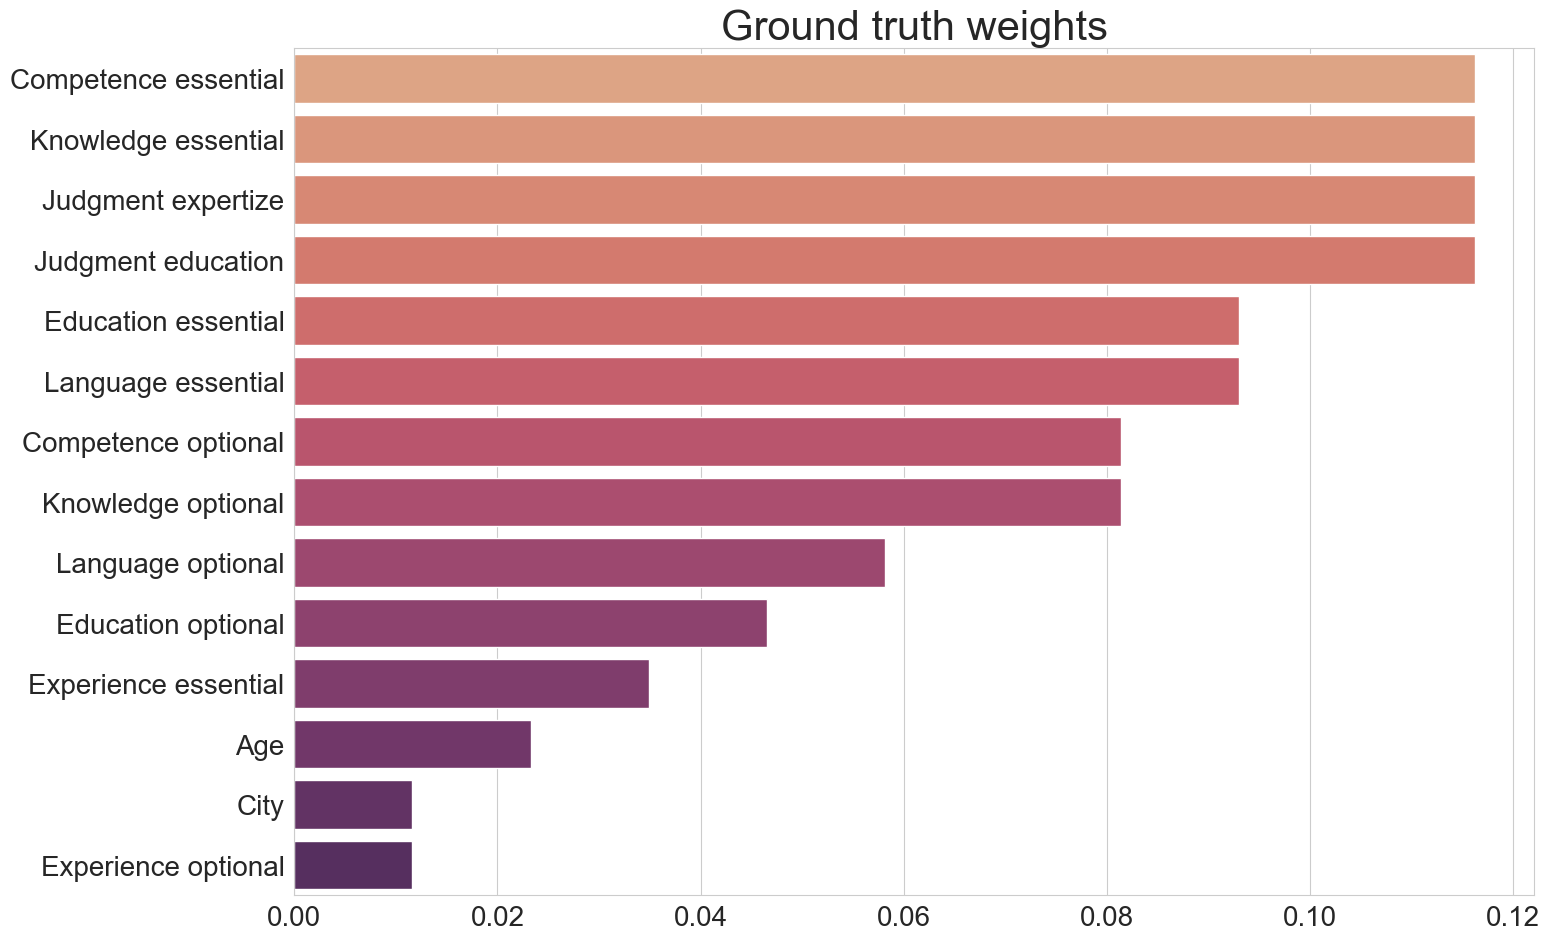

In [43]:
ground_truth = pd.DataFrame(list(matching_par["weight"].items()), columns=['feature', 'importance']) .sort_values(by="importance",ascending=False)

ground_truth["importance"] /= ground_truth["importance"].sum()
_, axs = plt.subplots(figsize=(16,11))
sns.barplot(x="importance", y="feature", data=ground_truth, palette="flare", ax=axs)
axs.set_title("Ground truth weights", fontsize=30)
axs.tick_params(axis='both', labelsize=20)
axs.set(xlabel="",ylabel="")
plt.show()

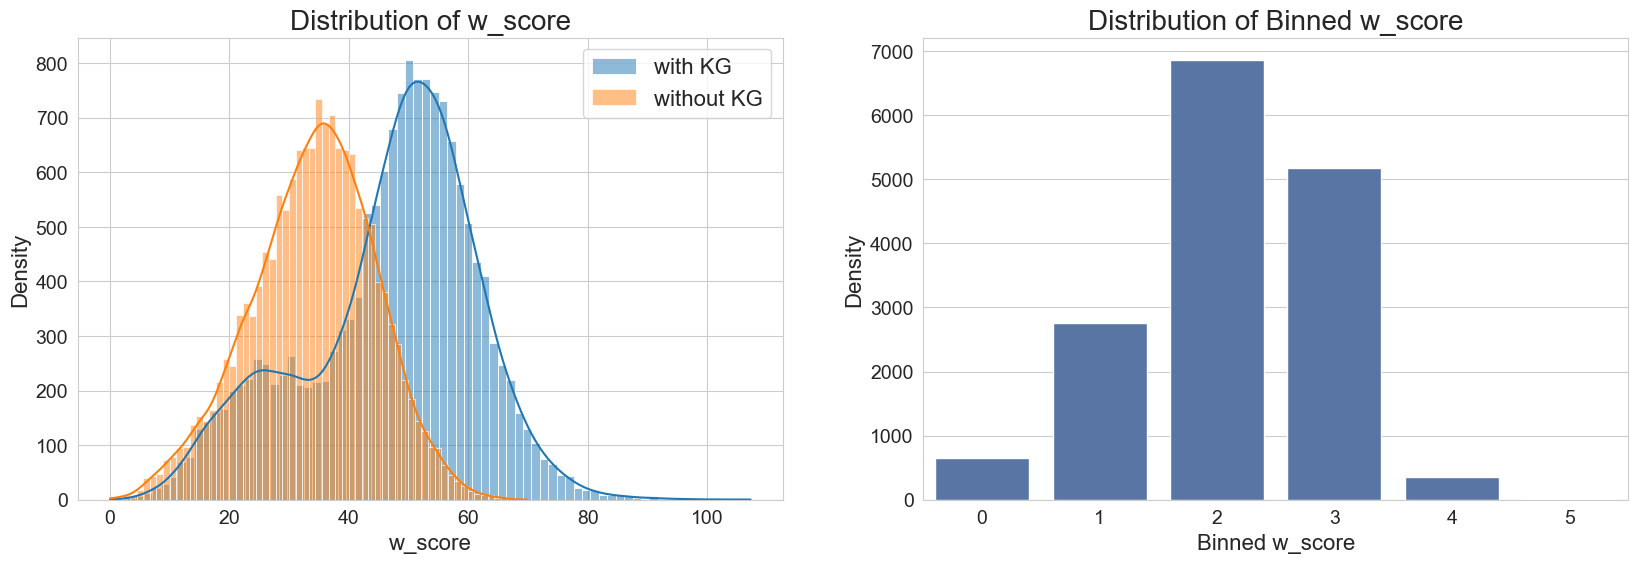

In [44]:
_, axs = plt.subplots(ncols=2,nrows=1, figsize=(20, 6))

w_score,binned_score = [],[]
for r in range(2):
    score_dt = pd.read_csv(f"../outputs/scores/{r}_dataset.csv")
    w_score.append(score_dt["w_score"].tolist())
    binned_score_ = score_dt["binned_score"].to_list()
    distri_labels = [binned_score_.count(i) for i in range(max(binned_score_)+1)]
    name_label = [*range(max(binned_score_)+1)]
    distri_labels = pd.DataFrame(distri_labels,index=name_label,columns=["Count"])
    binned_score.append(distri_labels)
    

sns.histplot(w_score[0], kde=True, label='with KG', ax=axs[0])
sns.histplot(w_score[1], kde=True, label='without KG', ax=axs[0])
axs[0].set_title('Distribution of w_score', fontsize=20)
axs[0].set_xlabel('w_score', fontsize=16)
axs[0].set_ylabel("Density", fontsize=16)
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(fontsize=16)

sns.barplot(x=binned_score[0].index,y=binned_score[0]["Count"],data=binned_score[0],
            color="#4C72B0",ax=axs[1])

axs[1].set_title('Distribution of Binned w_score', fontsize=20)
axs[1].set_xlabel('Binned w_score', fontsize=16)
axs[1].set_ylabel("Density", fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)

plt.show()

# Fitness functions

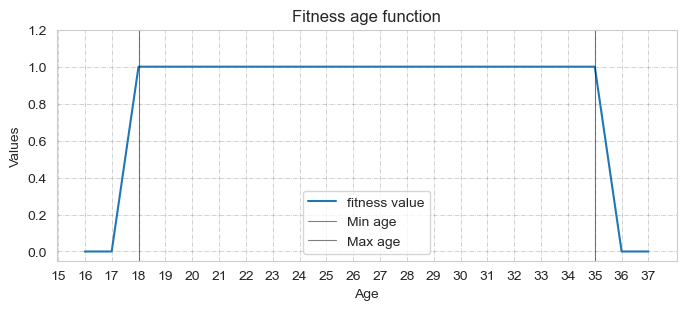

In [45]:
min_age, max_age = 18, 35
ages = [*range(16,37+1)]
age_score = [FitnessAge.fitness_basic(i,min_age,max_age) for i in ages]

_, axs = plt.subplots(figsize=(8,3))

sns.lineplot(x=ages,y=age_score, label="fitness value",ax=axs)
axs.axvline(min_age, alpha=0.5,linewidth=0.8, color="black", label="Min age")
axs.axvline(max_age, alpha=0.5,linewidth=0.8, color="black", label="Max age")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_ylim(-0.05,1.2)
axs.set_xticks(np.arange(15, 37 + 1, 1))
axs.set_title("Fitness age function")
axs.set_xlabel('Age')
axs.set_ylabel('Values')
axs.legend()
plt.show()

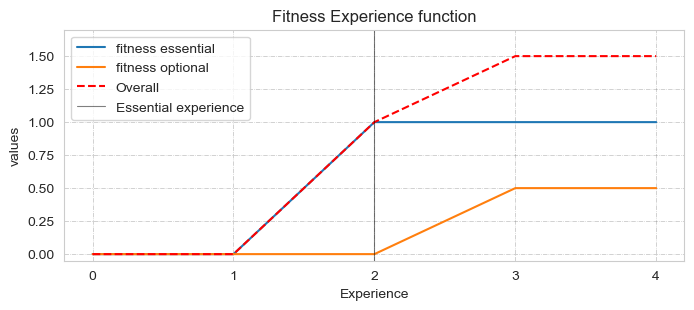

In [46]:
exp_essential,exp_optional = 2, True
experience = [*range(0,5)]

basic_score, bonus_score = [], []
for i in experience:
    a = FitnessExperience.fitness_basic(exp_essential,i)
    b = FitnessExperience.fitness_bonus(exp_essential, exp_optional, i)
    basic_score.append(a)
    bonus_score.append(b)

overall = [a + b for a,b in zip(basic_score,bonus_score)]
_, axs = plt.subplots(figsize=(8,3))

sns.lineplot(x=experience, y=basic_score, label="fitness essential")
sns.lineplot(x=experience, y=bonus_score, label="fitness optional")
sns.lineplot(x=experience, y=overall, color="red", linestyle="--", label="Overall")
axs.axvline(exp_essential, alpha=0.5,linewidth=0.8, color="black", label="Essential experience")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_ylim(-0.05,1.7)
axs.set_xticks(np.arange(0,5,1))
axs.set_title("Fitness Experience function")
axs.set_xlabel('Experience')
axs.set_ylabel('values')
axs.legend()
plt.show()

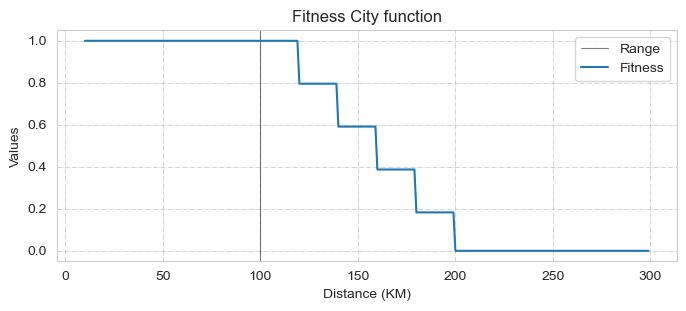

In [47]:
fitness_city = FitnessCity("../sources/cities_distance.csv")

range_ = 100
distances = [*range(10,300,1)]
fitness = [fitness_city.distance_scoring(d, range_) for d in distances]

_, axs = plt.subplots(figsize=(8,3))

axs.axvline(range_, alpha=0.5,linewidth=0.8, color="black", label="Range")
sns.lineplot(x=distances,y=fitness, label="Fitness")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_title("Fitness City function")
axs.set_xlabel('Distance (KM)')
axs.set_ylabel('Values')
axs.set_ylim(-0.05,1.05)

axs.legend()
plt.show()

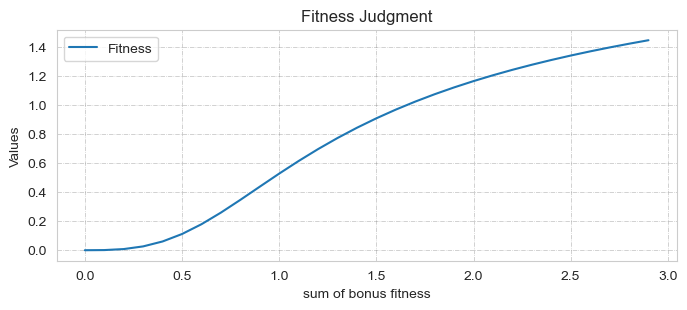

In [48]:
fitness_judgment = FitnessJudgment()

values = [*np.arange(0,3,0.1)]
fitness = [fitness_judgment.fitness_basic([c]) for c in values]

_, axs = plt.subplots(figsize=(8, 3))

sns.lineplot(x=values, y=fitness, label="Fitness")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_title("Fitness Judgment")
axs.set_xlabel('sum of bonus fitness')
axs.set_ylabel('Values')

axs.legend()
plt.show()

# Distributions of models' scores

In [49]:
with open("../Models/GlassBox/figs/saved_models/FIGSReg.pkl", 'rb') as file:
    model_figs = pickle.load(file)
with open("../Models/GlassBox/ebm/saved_models/EBMReg.pkl", 'rb') as file:
    model_ebm = pickle.load(file)
with open("../Models/BlackBox/lmart/saved_models/LGBMRanker.pkl", 'rb') as file:
    model_lgbm = pickle.load(file)

In [50]:
dataset0 = pd.read_csv("../outputs/scores/0_dataset.csv")
dataset1 = pd.read_csv("../outputs/scores/1_dataset.csv")

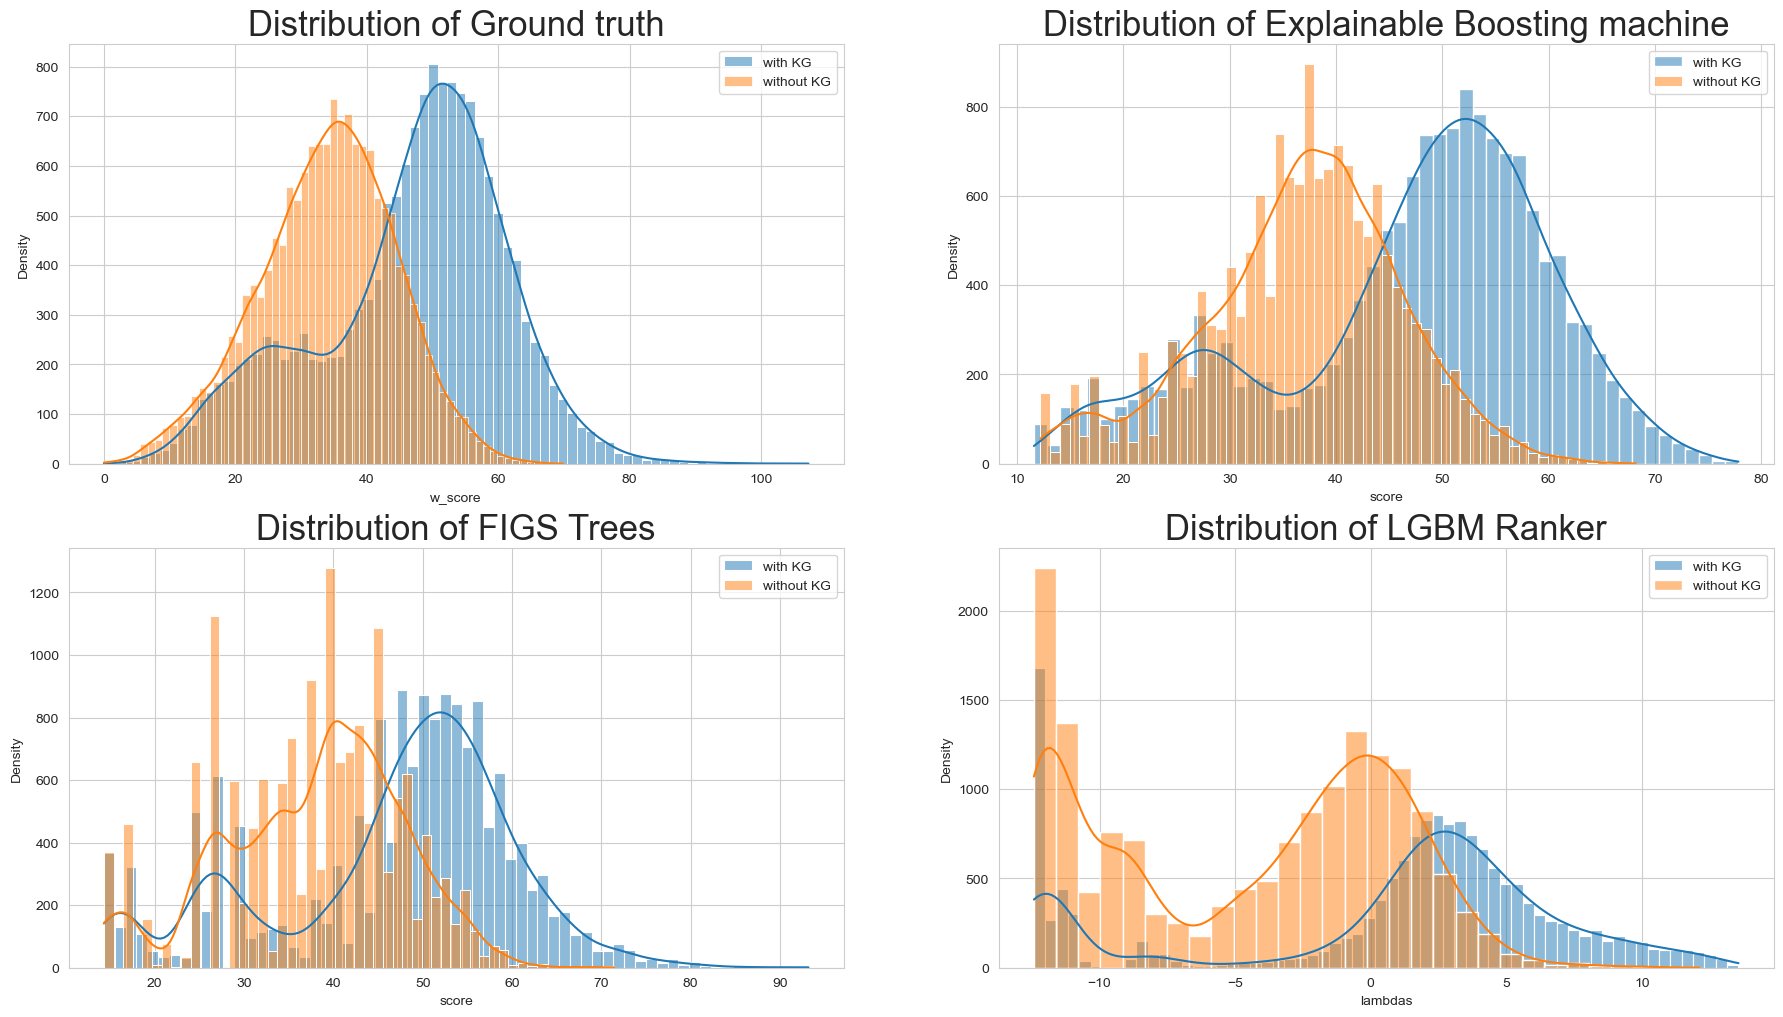

In [51]:
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(22, 12))

ebm_score0 = model_ebm.predict(dataset0.iloc[:,5:].to_numpy())
figs_score0 = model_figs.predict(dataset0.iloc[:,5:].to_numpy())
lgbm_score0 = model_lgbm.predict(dataset0.iloc[:,5:].to_numpy())
ebm_score1 = model_ebm.predict(dataset1.iloc[:,5:].to_numpy())
figs_score1 = model_figs.predict(dataset1.iloc[:,5:].to_numpy())
lgbm_score1 = model_lgbm.predict(dataset1.iloc[:,5:].to_numpy())

sns.histplot(dataset0["w_score"], kde=True, label='with KG', ax=axs[0,0])
sns.histplot(dataset1["w_score"], kde=True, label='without KG', ax=axs[0,0])
axs[0,0].set_title('Distribution of Ground truth', fontsize=25)
axs[0,0].set(xlabel="w_score",ylabel="Density")
axs[0,0].legend()

sns.histplot(ebm_score0,kde=True, label='with KG', ax=axs[0,1])
sns.histplot(ebm_score1,kde=True, label='without KG', ax=axs[0,1])
axs[0,1].set_title('Distribution of Explainable Boosting machine', fontsize=25)
axs[0,1].set(xlabel="score",ylabel="Density")
axs[0,1].legend()

sns.histplot(figs_score0, kde=True, label='with KG', ax=axs[1,0])
sns.histplot(figs_score1, kde=True, label='without KG', ax=axs[1,0])
axs[1,0].set_title('Distribution of FIGS Trees', fontsize=25)
axs[1,0].set(xlabel="score",ylabel="Density")
axs[1,0].legend()

sns.histplot(lgbm_score0, kde=True, label='with KG', ax=axs[1,1])
sns.histplot(lgbm_score1, kde=True, label='without KG', ax=axs[1,1])
axs[1,1].set_title('Distribution of LGBM Ranker', fontsize=25)
axs[1,1].set(xlabel="lambdas",ylabel="Density")
axs[1,1].legend()

plt.show()

# Consistent curricula

In [52]:
curricula = pd.read_csv("../outputs/0_curricula.csv",usecols=[0,1,2]).set_index("kId")
dataset = pd.read_csv("../outputs/scores/0_dataset.csv").set_index("kId")

In [53]:
curricula = pd.concat([curricula, pd.json_normalize(curricula['metadata'].apply(ast.literal_eval))],
                      axis=1)["consistent"]
curricula.index.rename("kId", inplace=True)

curricula = dataset.merge(curricula, on="kId")[["w_score","consistent"]]
curricula['consistent'] = curricula['consistent'].astype(int)
lambda_figs = model_figs.predict(dataset.iloc[:, 4:].to_numpy())
lambda_ebm = model_ebm.predict(dataset.iloc[:, 4:].to_numpy())
lambda_lgbm = model_lgbm.predict(dataset.iloc[:, 4:].to_numpy())

predictions = [
    pd.DataFrame({'score': lambda_lgbm, 'ax_': np.ones_like(lambda_lgbm.T) * 4, 'c': curricula['consistent']}),
    pd.DataFrame({'score': lambda_figs, 'ax_': np.ones_like(lambda_figs.T) * 3, 'c': curricula['consistent']}),
    pd.DataFrame({'score': lambda_ebm, 'ax_': np.ones_like(lambda_ebm.T) * 2, 'c': curricula['consistent']}),
    pd.DataFrame({'score': curricula["w_score"].to_numpy(), 'ax_': np.ones_like(curricula["w_score"].to_numpy().T) * 1, 'c': curricula['consistent']})
]

predictions = pd.concat(predictions)

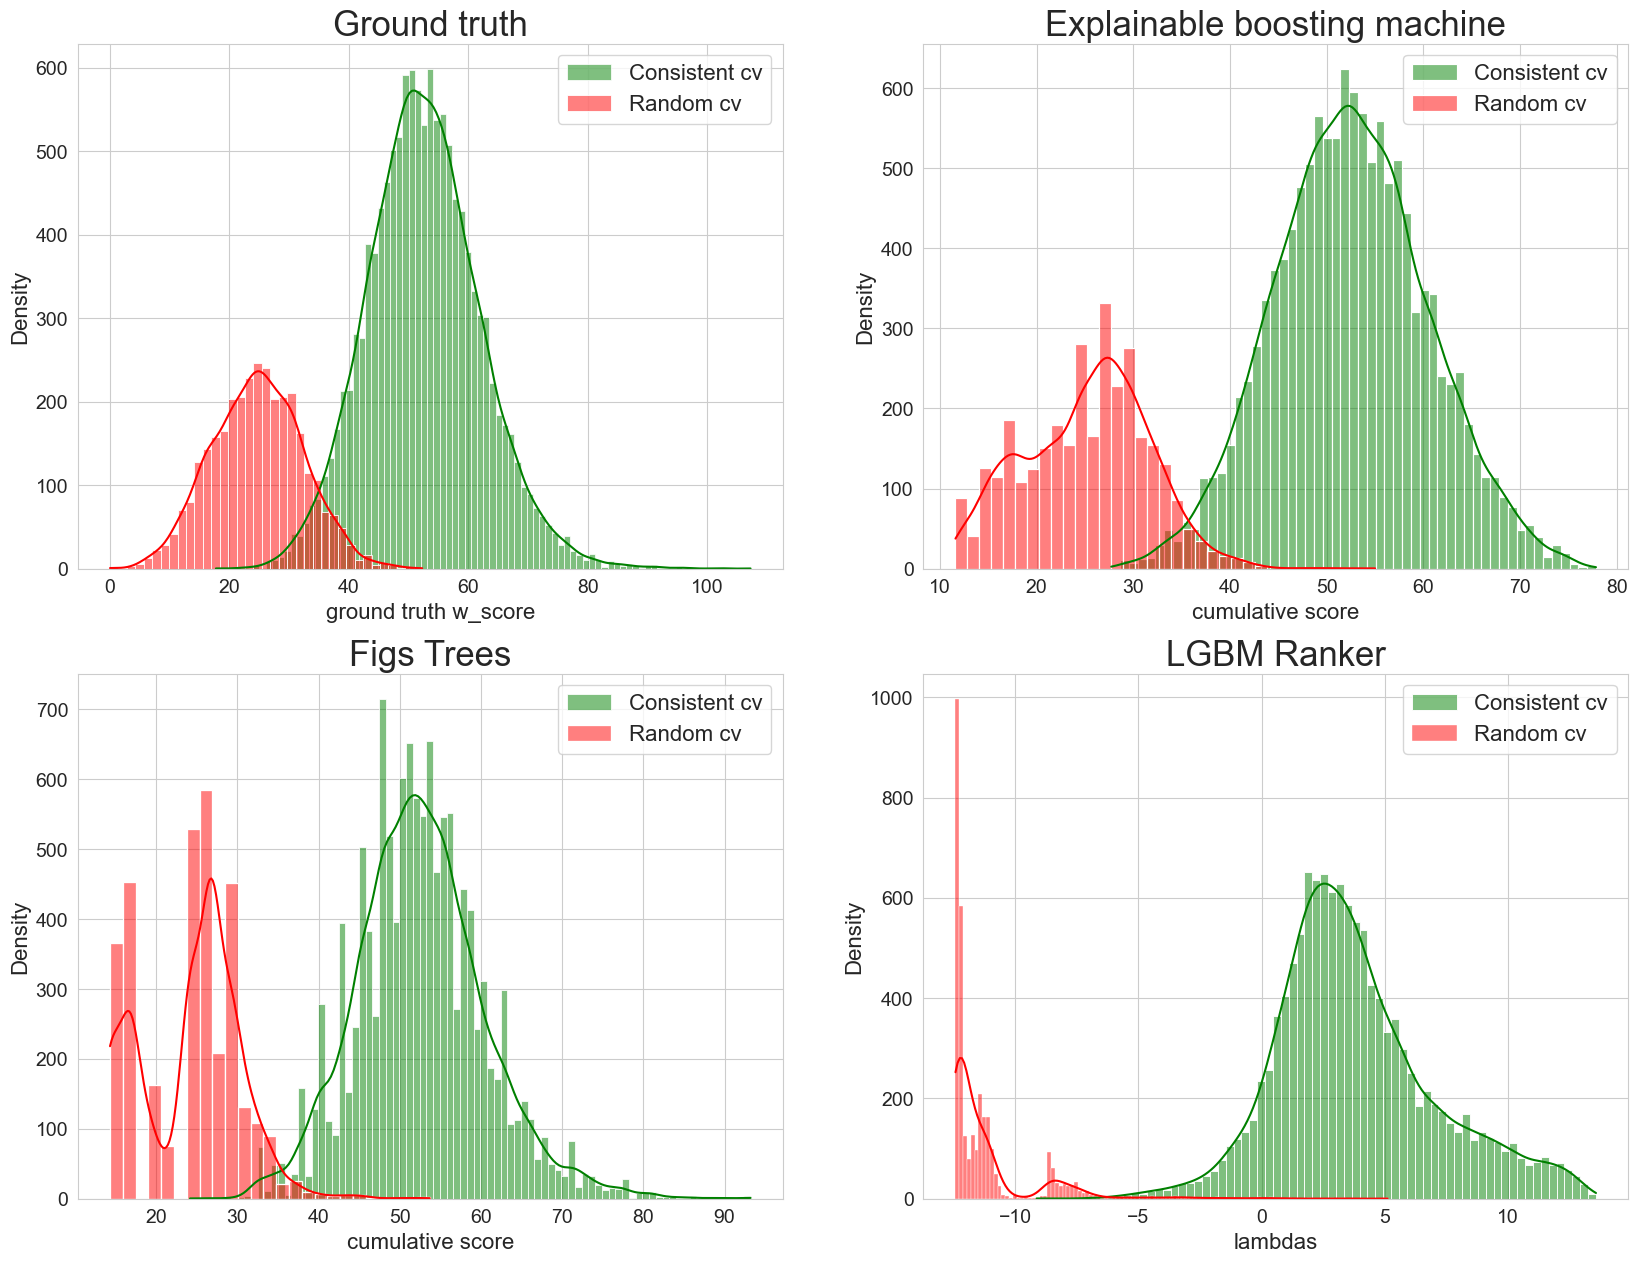

In [56]:
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

models = [1, 2, 3, 4]
titles = ["Ground truth", "Explainable boosting machine", "Figs Trees", "LGBM Ranker"]
labels = ["ground truth w_score", "cumulative score", "cumulative score", "lambdas"]

for i, model in enumerate(models, start=1):
    consistent_data = predictions[(predictions["c"] == 1) & (predictions["ax_"] == model)]["score"]
    random_data = predictions[(predictions["c"] == 0) & (predictions["ax_"] == model)]["score"]

    sns.histplot(consistent_data, kde=True, color="green", label="Consistent cv", ax=axs.flatten()[i-1])
    sns.histplot(random_data, kde=True, color="red", label="Random cv", ax=axs.flatten()[i-1])

    axs.flatten()[i-1].set_title(titles[i-1], fontsize=25)
    
    axs.flatten()[i-1].set_xlabel(labels[i-1], fontsize=16)
    axs.flatten()[i-1].set_ylabel("Density", fontsize=16)
    axs.flatten()[i-1].tick_params(axis='both', labelsize=14)    
    axs.flatten()[i-1].legend(fontsize=16)

plt.show()

# Advanced Binning

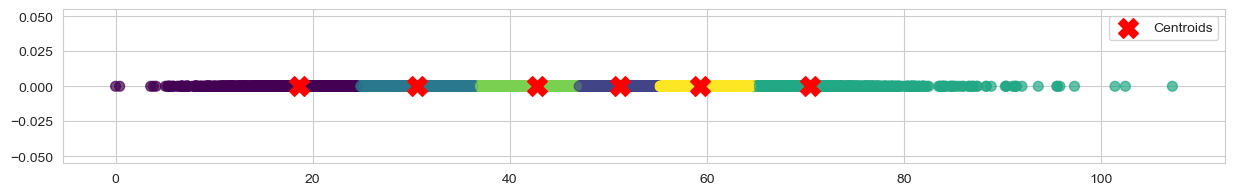

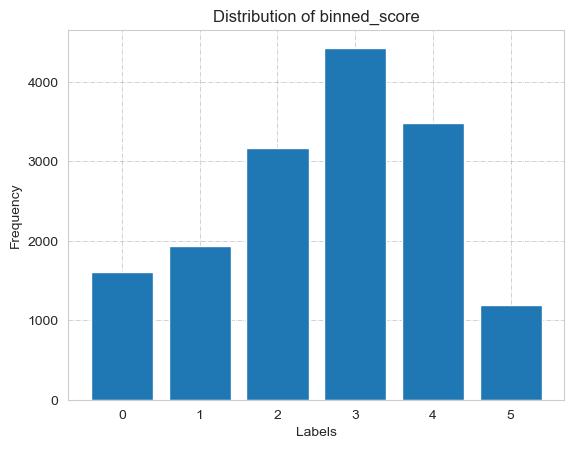

In [55]:
w_score = pd.read_csv("../outputs/scores/0_dataset.csv",usecols=[3]).to_numpy()

n_cluster = 6
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init="auto")
kmeans.fit(w_score)


clusters = pd.DataFrame(kmeans.cluster_centers_,columns=["clus_pos"])
clusters["rank"] =clusters.clus_pos.rank().astype(int)-1
map_dict = clusters["rank"].to_dict()
labeled = list(map(lambda x: map_dict[x], kmeans.labels_))
distri_labels = [labeled.count(i) for i in range(max(labeled)+1)]
name_label = [*range(max(labeled)+1)]


plt.figure(figsize=(15,2))
plt.scatter(w_score, np.zeros_like(w_score), c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_, np.zeros_like(kmeans.cluster_centers_), c='red', marker='X', s=200, label='Centroids')
plt.legend()
plt.show()

plt.bar(name_label, distri_labels)
plt.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.title('Distribution of binned_score')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()